## Data used: http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

---
The
dataset is comprised of 1,000 positive and 1,000 negative movie reviews


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import nltk
nltk.download('stopwords')

In [0]:
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from pandas import DataFrame
from matplotlib import pyplot

# Store the Vocabulary

---


In [0]:
# load doc into memory
def load_doc(filename):

  # open the file as read only
  file = open(filename, 'r')

  # read all text
  text = file.read()

  # close the file
  file.close()

  return text


# turn a doc into clean tokens
def clean_doc(doc):

  # split into tokens by white space
  tokens = doc.split()

  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]

  # remove remaining tokens that are not alphabetic
  tokens = [word for word in tokens if word.isalpha()]

  # filter out stop words
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]

  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]

  return tokens 


# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):

  # load doc
  doc = load_doc(filename)

  # clean doc
  tokens = clean_doc(doc)

  # update counts
  vocab.update(tokens)  


# load all docs in a directory
def process_docs(directory, vocab):
  # walk through all files in the folder
  for filename in listdir(directory):
    # skip files that do not have the right extension
    if not filename.endswith(".txt"):
      next

    # create the full path of the file to open
    path = directory + '/' + filename

    # add doc to vocab
    add_doc_to_vocab(path, vocab) 


# save list to file
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)  
  file.close()   

In [0]:
# define vocab
vocab = Counter()

# add all docs to vocab
process_docs("/content/gdrive/My Drive/NLP_Projects/4/txt_sentoken/neg", vocab)
process_docs("/content/gdrive/My Drive/NLP_Projects/4/txt_sentoken/pos", vocab)

# print the size of the vocab
print(len(vocab))

# print the top words in the vocab
print(vocab.most_common(50))

# keep tokens with > 2 occurrence
min_occurence = 2
tokens = [k for k,c in vocab.items() if c >= min_occurence]
print(len(tokens))

# save tokens to a vocabulary file
save_list(tokens, "/content/gdrive/My Drive/NLP_Projects/4/vocab.txt")

46557
[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]
27139


# Splitting the data as train and test

---



In [0]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
  # load the doc
  doc = load_doc(filename)

  # clean doc
  tokens = clean_doc(doc)

  # filter by vocab
  tokens = [w for w in tokens if w in vocab]

  return ' '.join(tokens)


# load all docs in a directory
def process_docs(directory, vocab, is_train):
  lines = list()

  # walk through all files in the folder
  for filename in listdir(directory):

    # skip any reviews in the test set
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    # create the full path of the file to open
    path = directory + '/' + filename
    # load and clean the doc
    line = doc_to_line(path, vocab)
    # add to list
    lines.append(line)

  return lines


# load and clean a dataset
def load_clean_dataset(vocab, is_train):
  # load documents
  neg = process_docs("/content/gdrive/My Drive/NLP_Projects/4/txt_sentoken/neg", vocab, is_train)
  pos = process_docs("/content/gdrive/My Drive/NLP_Projects/4/txt_sentoken/pos", vocab, is_train)
  docs = neg + pos

  # prepare labels
  labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]

  return docs, labels


# fit a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer   

In [7]:
# load the vocabulary
vocab_filename = "/content/gdrive/My Drive/NLP_Projects/4/vocab.txt"
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)

# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 26897) (200, 26897)


# MLP for Sentiment Analysis

---



In [0]:
# define the model
def define_model(n_words):
  # define network
  model = Sequential()
  model.add(Dense(50, input_shape=(n_words,), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # compile network
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


# evaluate a neural network model
def evaluate_model(Xtrain, ytrain, Xtest, ytest):
  scores = list()
  n_repeats = 10
  n_words = Xtest.shape[1]
  for i in range(n_repeats):
    # define network
    model = define_model(n_words)

    # fit network
    model.fit(Xtrain, ytrain, epochs=10, verbose=0)

    # evaluate
    _, acc = model.evaluate(Xtest, ytest, verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' % ((i+1), acc))

  return scores


# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
  # create the tokenizer
  tokenizer = Tokenizer()

  # fit the tokenizer on the documents
  tokenizer.fit_on_texts(train_docs)

  # encode training data set
  Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)

  # encode training data set
  Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)

  return Xtrain, Xtest  

1 accuracy: 0.9200000166893005
2 accuracy: 0.9200000166893005
3 accuracy: 0.9300000071525574
4 accuracy: 0.9100000262260437
5 accuracy: 0.9200000166893005
6 accuracy: 0.9200000166893005
7 accuracy: 0.9150000214576721
8 accuracy: 0.9200000166893005
9 accuracy: 0.9200000166893005
10 accuracy: 0.9300000071525574
1 accuracy: 0.8949999809265137
2 accuracy: 0.8999999761581421
3 accuracy: 0.8899999856948853
4 accuracy: 0.8700000047683716
5 accuracy: 0.8999999761581421
6 accuracy: 0.8949999809265137
7 accuracy: 0.9049999713897705
8 accuracy: 0.8799999952316284
9 accuracy: 0.8949999809265137
10 accuracy: 0.8999999761581421
1 accuracy: 0.8450000286102295
2 accuracy: 0.8899999856948853
3 accuracy: 0.8550000190734863
4 accuracy: 0.8799999952316284
5 accuracy: 0.8799999952316284
6 accuracy: 0.8600000143051147
7 accuracy: 0.8650000095367432
8 accuracy: 0.8849999904632568
9 accuracy: 0.8700000047683716
10 accuracy: 0.8550000190734863
1 accuracy: 0.8600000143051147
2 accuracy: 0.8700000047683716
3 acc

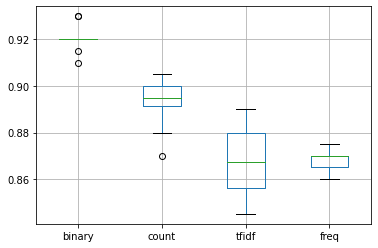

In [12]:
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
  # prepare data for mode
  Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)

  # evaluate model on data for mode
  results[mode] = evaluate_model(Xtrain, ytrain, Xtest, ytest)

# summarize results
print(results.describe())

# plot results
results.boxplot()
pyplot.show()

# Predicting Sentiment for New Reviews

---

Considering above results, it can be seen that 'binary' mode gave the best accuracy value. Hence we will use this mode for predicting on a new review.

In [0]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
  # clean
  tokens = clean_doc(review)

  # filter by vocab
  tokens = [w for w in tokens if w in vocab]

  # convert to line
  line = ' '.join(tokens)

  # encode
  encoded = tokenizer.texts_to_matrix([line], mode='binary')

  # predict sentiment
  yhat = model.predict(encoded, verbose=0)

  # retrieve predicted percentage and label
  percent_pos = yhat[0,0]
  if round(percent_pos) == 0:
    return (1-percent_pos), 'NEGATIVE'
  return percent_pos, 'POSITIVE'

In [15]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')

# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)

# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)


Epoch 1/10
 - 1s - loss: 0.4687 - accuracy: 0.7800
Epoch 2/10
 - 0s - loss: 0.0563 - accuracy: 0.9944
Epoch 3/10
 - 0s - loss: 0.0149 - accuracy: 1.0000
Epoch 4/10
 - 0s - loss: 0.0070 - accuracy: 1.0000
Epoch 5/10
 - 0s - loss: 0.0038 - accuracy: 1.0000
Epoch 6/10
 - 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 7/10
 - 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 8/10
 - 0s - loss: 8.4596e-04 - accuracy: 1.0000
Epoch 9/10
 - 0s - loss: 5.8451e-04 - accuracy: 1.0000
Epoch 10/10
 - 0s - loss: 4.2789e-04 - accuracy: 1.0000


In [16]:

# test positive text
text = 'Best movie ever! It was great, I recommend it.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (58.036%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (64.994%)
